# Water detection example

This method uses the steps described in:

_Donchyts, G., Schellekens, J., Winsemius, H., Eisemann, E., Van de Giesen, N., 2016. A 30 m resolution surface water mask including estimation of positional and thematic differences using landsat 8, srtm and openstreetmap: a case study in the Murray-Darling Basin, Australia. Remote Sensing 8, 386._

The examples below are somewhat optimized (by setting the configuration values) but more improvement and finetuning is possible. The example uses sentinel-2 data.

In [4]:
import rasterio
import os
from rasterio.mask import mask
import matplotlib.pyplot as plt
%matplotlib inline
from rasterio.plot import show
from xml.dom import minidom
import numpy as np
import geopandas as gpd
from dryspy import co_wdetect

We use the following three bands from sentinel-2 downloaded from EO browser fro the region around Amsterdam (NL) in this example:

- Band 3 – Green
- Band 8 – NIR
- Band 11 – SWIR	1613.7

In [5]:
B8_  = rasterio.open('EO_Browser_images/2019-06-07-00:00_2019-06-07-23:59_Sentinel-2_L1C_B08_(Raw).tiff')
B11_  = rasterio.open('EO_Browser_images/2019-06-07-00:00_2019-06-07-23:59_Sentinel-2_L1C_B11_(Raw).tiff')
B3_ = rasterio.open('EO_Browser_images/2019-06-07-00:00_2019-06-07-23:59_Sentinel-2_L1C_B03_(Raw).tiff')

# Apply the scaling
B8 = B8_.read()/100000
B11 = B11_.read()/100000
B3 = B3_.read()/100000

# Waterdetect assumes missing values are set to np.nan so we do that here
B8 = np.where(B8 <= 0.001, np.nan, B8)
B3 = np.where(B3 <= 0.001, np.nan, B3)
B11 = np.where(B11 <= 0.001, np.nan, B11)

# Next we calculate nwdi from swir and nir
ndwi_swir = (B3 - B11)/(B3 + B11)
ndwi_nir = (B3 - B8)/(B3 + B8)

First plot the three bands we use as well as the ndwi based on swir and nir

Text(0.5, 1.0, 'swir')

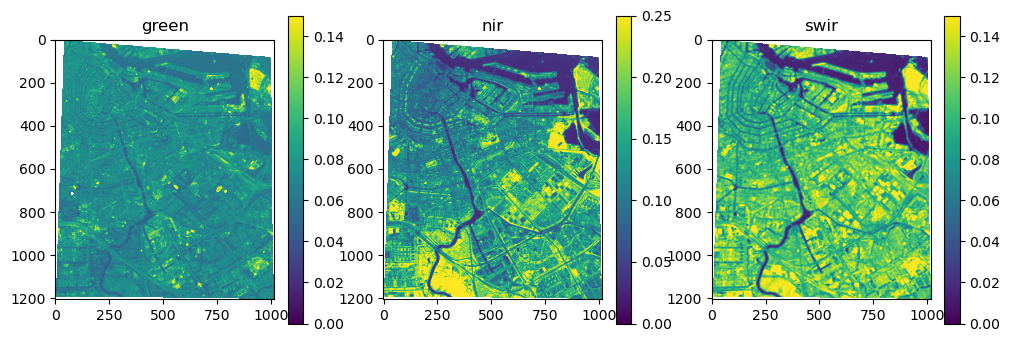

In [6]:
fig, ax =plt.subplots(1,3, figsize = (12,4))
im = ax[0].imshow(B3[0,:,:], vmin=0, vmax=0.15)
plt.colorbar(im)
im = ax[1].imshow(B8[0,:,:], vmin=0, vmax=0.25)
plt.colorbar(im)
im = ax[2].imshow(B11[0,:,:], vmin=0, vmax=0.15)
plt.colorbar(im)
ax[0].set_title('green')
ax[1].set_title('nir')
ax[2].set_title('swir')

Text(0.5, 1.0, 'ndwi (swir)')

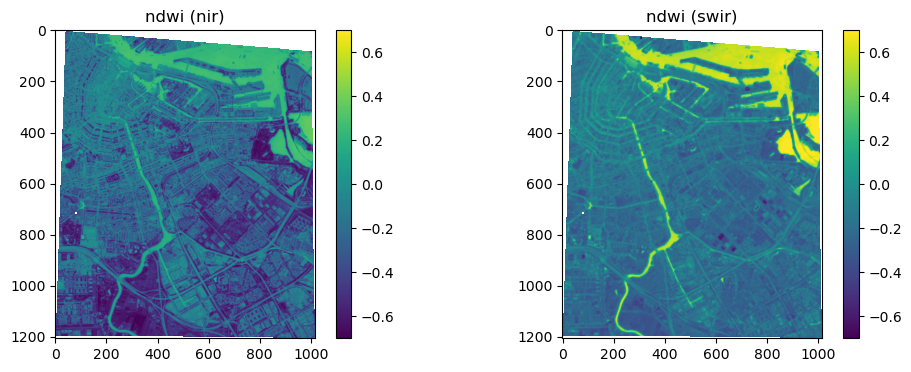

In [7]:
fig, ax =plt.subplots(1,2, figsize = (12,4))
im = ax[0].imshow(ndwi_nir[0,:,:], vmin=-0.7, vmax=0.7)
plt.colorbar(im)
im = ax[1].imshow(ndwi_swir[0,:,:], vmin=-0.7, vmax=0.7)
plt.colorbar(im)

ax[0].set_title('ndwi (nir)')
ax[1].set_title('ndwi (swir)')

First we use two ndwi versions, calculated with nir and with swir to detect water.

In [8]:
config = {"edge_detection": {
            "histogram_scale_maxvalue": 100,
            "histogram_scale_minvalue": 87,
            "sigma": 2.5,
            "classes": 2,
            "threshold_multiplication":1.0,
            "buffer": 4
            },
            "data_clean": 
            {"min_size": 8,
            "dilation_erosion_size": 4
            },
}
wd = co_wdetect.canny_otsu_water_detect(config)
water_nir_ndwi = wd.detect_water(ndwi_nir[0,:,:], th_direction='larger')
nir_ndwi_edges = wd.canny_buffedges.copy()

config = {"edge_detection": {
            "histogram_scale_maxvalue": 100,
            "histogram_scale_minvalue": 80,
            "sigma": 2.5,
            "classes": 4,
            "threshold_multiplication":1.0,
            "buffer": 4
            },
            "data_clean": 
            {"min_size": 8,
            "dilation_erosion_size": 4
            },
}
wd = co_wdetect.canny_otsu_water_detect(config)
water_swir_ndwi = wd.detect_water(ndwi_swir[0,:,:], th_direction='larger')
swir_ndwi_edges = wd.canny_buffedges.copy()

Text(0.5, 1.0, 'edges_swir_ndwi')

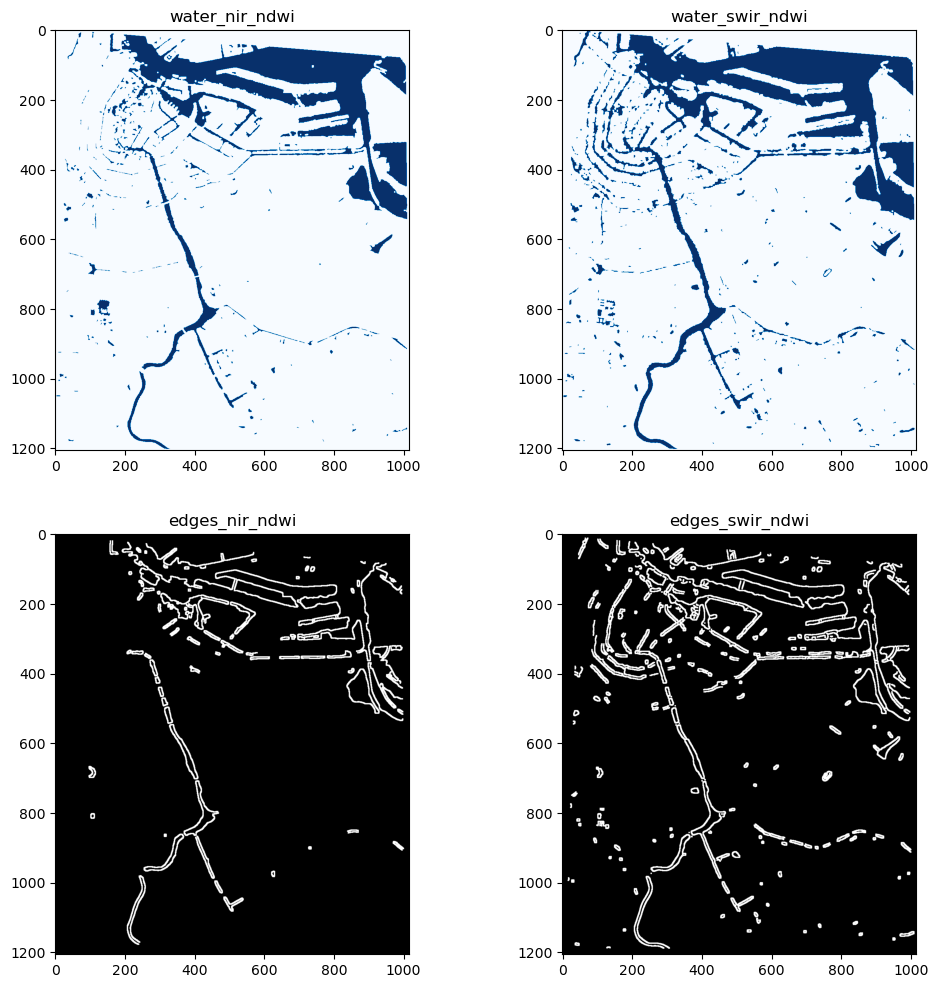

In [10]:
fig, ax =plt.subplots(2,2, figsize = (12,12))

im = ax[0,0].imshow(water_nir_ndwi, vmin=0, vmax=1, cmap='Blues')
im = ax[0,1].imshow(water_swir_ndwi, vmin=0, vmax=1, cmap='Blues')
ax[0,0].set_title('water_nir_ndwi')
ax[0,1].set_title('water_swir_ndwi')

im = ax[1,0].imshow(nir_ndwi_edges, vmin=0, vmax=1, cmap='gray')
im = ax[1,1].imshow(swir_ndwi_edges, vmin=0, vmax=1, cmap='gray')
ax[1,0].set_title('edges_nir_ndwi')
ax[1,1].set_title('edges_swir_ndwi')

Now detect water from nir and swir only

In [15]:
config = {"edge_detection": {
            "histogram_scale_maxvalue": 30,
            "histogram_scale_minvalue": 0,
            "sigma": 4.0,
            "classes": 4,
            "threshold_multiplication": 1.0,
            "buffer": 4
            },
            "data_clean": 
            {"min_size": 8,
            "dilation_erosion_size": 4
            },

}
wd = co_wdetect.canny_otsu_water_detect(config)
water_nir = wd.detect_water(B8[0,:,:], th_direction='smaller')
nir_edges = wd.canny_buffedges.copy()

config = {"edge_detection": {
            "histogram_scale_maxvalue": 30,
            "histogram_scale_minvalue": 0,
            "sigma": 4.0,
            "classes": 2,
            "threshold_multiplication": 1.0,
            "buffer": 4
            },
            "data_clean": 
            {"min_size": 8,
            "dilation_erosion_size": 4
            },

}
wd = co_wdetect.canny_otsu_water_detect(config)
water_swir = wd.detect_water(B11[0,:,:], th_direction='smaller', apply_secondary_filter=True, apply_uncertainty_filter=True)
swir_edges = wd.canny_buffedges.copy()

Text(0.5, 1.0, 'edges_swir')

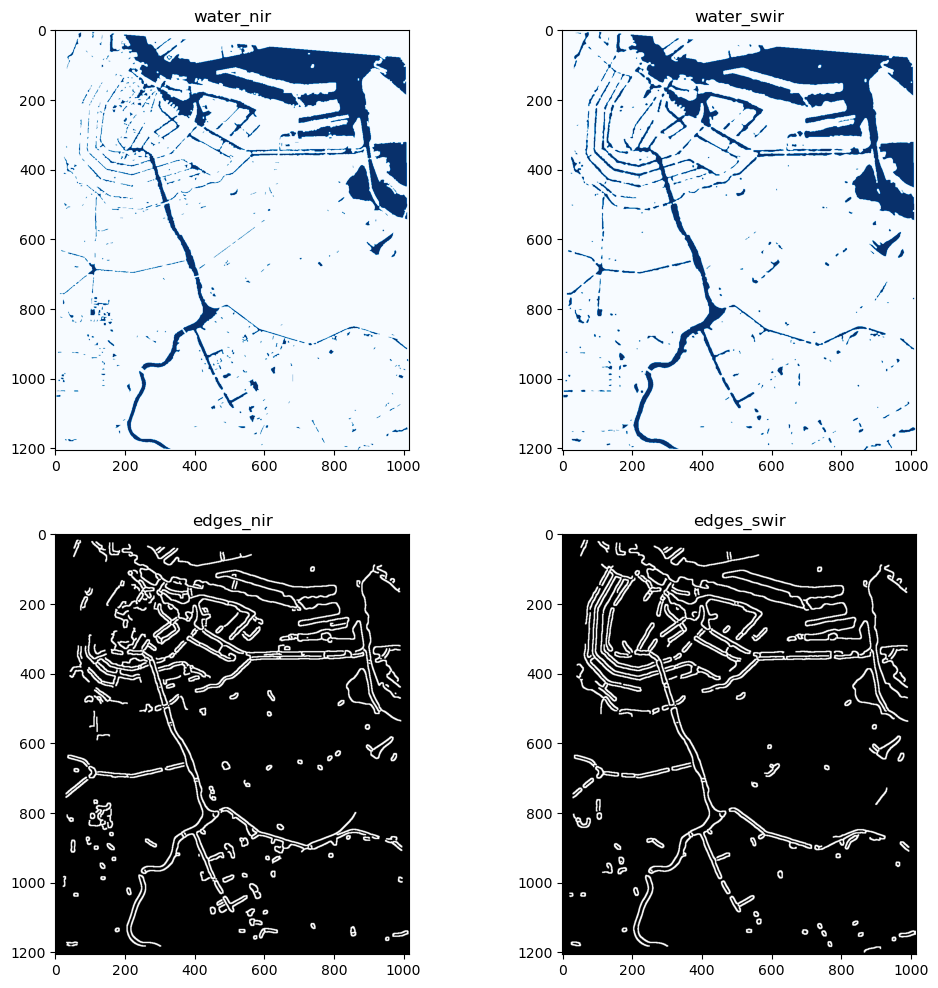

In [16]:
fig, ax =plt.subplots(2,2, figsize = (12,12))

im = ax[0,0].imshow(water_nir, vmin=0, vmax=1, cmap='Blues')
im = ax[0,1].imshow(water_swir, vmin=0, vmax=1, cmap='Blues')
ax[0,0].set_title('water_nir')
ax[0,1].set_title('water_swir')

im = ax[1,0].imshow(nir_edges, vmin=0, vmax=1, cmap='gray')
im = ax[1,1].imshow(swir_edges, vmin=0, vmax=1, cmap='gray')
ax[1,0].set_title('edges_nir')
ax[1,1].set_title('edges_swir')

Save the detected water using the different bands/indices as geotif files

In [ ]:
with rasterio.open(fp='water_nir.tif',
    mode="w",
    **B8_.meta,  # outputpath_name
) as dst:
    dst.write(np.array([water_nir]) * 10000)

with rasterio.open(fp='water_swir.tif',
    mode="w",
    **B8_.meta,  # outputpath_name
) as dst:
    dst.write(np.array([water_swir]) * 10000)

with rasterio.open(fp='water_ndwi_swir.tif',
    mode="w",
    **B8_.meta,  # outputpath_name
) as dst:
    dst.write(np.array([water_swir_ndwi]) * 10000)

with rasterio.open(fp='water_ndwi_nir.tif',
    mode="w",
    **B8_.meta,  # outputpath_name
) as dst:
    dst.write(np.array([water_nir_ndwi]) * 10000)

In [ ]:
import sys
wd.config.write(sys.stdout)

In [18]:
wd.stats

{'hist_kurtosis': 0.14779123801451233,
 'hist_skew': -0.03211809497619542,
 '25': 0.05551,
 '75': 0.08985,
 'diptest': 0.0009814769578411632,
 'hist_slope': 312.7929973268972,
 'diff_in_out': -0.08064491172195856,
 'wb_area_1': 112961.0,
 'wb_mean_1': 0.023913110808155027,
 'wb_area_length_1': 939.1278669646991,
 'wb_area_length_short_1': 421.89707952949647,
 'wb_area_label_1': 5.0,
 'wb_area_2': 18509.0,
 'wb_mean_2': 0.03720227024690691,
 'wb_area_length_2': 923.6423037856173,
 'wb_area_length_short_2': 227.16417081083964,
 'wb_area_label_2': 47.0,
 'wb_area_3': 7740.0,
 'wb_mean_3': 0.021421786821705424,
 'wb_area_length_3': 144.2430167459123,
 'wb_area_length_short_3': 81.93429275747705,
 'wb_area_label_3': 64.0,
 'wb_area_4': 4052.0,
 'wb_mean_4': 0.030138998025666337,
 'wb_area_length_4': 276.1713466272781,
 'wb_area_length_short_4': 107.09987999875781,
 'wb_area_label_4': 236.0,
 'wb_area_5': 1805.0,
 'wb_mean_5': 0.03671321329639889,
 'wb_area_length_5': 94.36996426319108,
 'wb